In [1]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus

In [2]:
from xidplus import sed
SEDs,df =sed.mrr_templates()

0.0001
0.0001
0.0001
0.0001


In [3]:
import pystan

In [4]:
code="""
// Fit the hyperparameters of a latent-variable Gaussian process with an
// exponentiated quadratic kernel and a Gaussian likelihood and predict
// out-of-sample observations

data {
  int<lower=1> N1;
  real x1[N1];
  vector[N1] y1;
  int<lower=1> N2;
  real x2[N2];
}
transformed data {
  real delta = 1e-9;
  int<lower=1> N = N1 + N2;
  real x[N];
  for (n1 in 1:N1) x[n1] = x1[n1];
  for (n2 in 1:N2) x[N1 + n2] = x2[n2];
}
parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
  vector[N] eta;
}
transformed parameters {
  vector[N] f;
  {
    matrix[N, N] L_K;
    matrix[N, N] K = cov_exp_quad(x, alpha, rho);
  
    // diagonal elements
    for (n in 1:N)
      K[n, n] = K[n, n] + delta;
    
    L_K = cholesky_decompose(K);
    f = L_K * eta;
  }
}
model {
  rho ~ inv_gamma(5, 5);
  alpha ~ normal(0, 5);
  sigma ~ normal(0, 0.01);
  eta ~ normal(0, 1);

  y1 ~ normal(f[1:N1], sigma);
}
generated quantities {
  vector[N2] y2;
  for (n2 in 1:N2)
    y2[n2] = normal_rng(f[N1 + n2], sigma);
}
"""

In [5]:
sm=pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_704128430b2e65b20cb8cd7d3976cd8c NOW.


In [53]:
red=np.arange(0,8,0.01)
red[0]=0.000001
fit_data={'N1':SEDs[0,0,250:350].size,
      'x1':red[250:350],
      'y1':np.log10(SEDs[0,0,250:350]),
      'N2':1,
      'x2':[3]
     }

In [54]:
fit=sm.sampling(data=fit_data, iter=1000,chains=2)

In [55]:
from xidplus.stan_fit import stan_utility as su

In [56]:
su.check_div(fit)

0.0 of 1000 iterations ended with a divergence (0.0%)


In [57]:
su.check_energy(fit)

In [58]:
su.check_treedepth(fit)

1000 of 1000 iterations saturated the maximum tree depth of 10 (100.0%)
Run again with max_depth set to a larger value to avoid saturation


In [59]:
samples=fit.extract()

In [11]:
plt.plot(red[250:350],np.median(samples['f'],axis=0)[0:-1])
plt.plot(red,np.log10(SEDs[0,0,:]))

NameError: name 'samples' is not defined

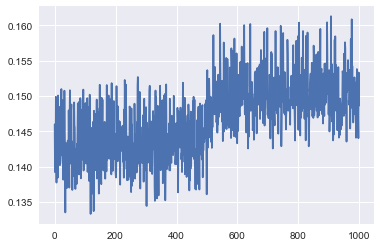

In [68]:
plt.plot(samples['rho'])

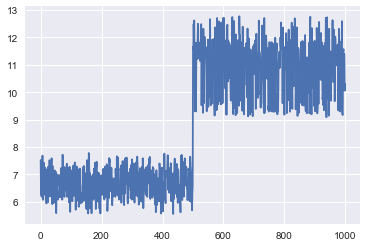

In [70]:
plt.plot(samples['alpha'])

In [4]:
code="""
// Fit the hyperparameters of a latent-variable Gaussian process with an
// exponentiated quadratic kernel and a Gaussian likelihood and predict
// out-of-sample observations

data {
  int<lower=1> N1;
  real x1[N1];
  vector[N1] y1;
  int<lower=1> N2;
  real x2[N2];
}
transformed data {
  real delta = 1e-9;
  real rho = 0.15;
  real alpha = 10;
  real sigma = 0.01;
  int<lower=1> N = N1 + N2;
  real x[N];
  for (n1 in 1:N1) x[n1] = x1[n1];
  for (n2 in 1:N2) x[N1 + n2] = x2[n2];
}
parameters {
  vector[N] eta;
}
transformed parameters {
  vector[N] f;
  {
    matrix[N, N] L_K;
    matrix[N, N] K = cov_exp_quad(x, alpha, rho);
  
    // diagonal elements
    for (n in 1:N)
      K[n, n] = K[n, n] + delta;
    
    L_K = cholesky_decompose(K);
    f = L_K * eta;
  }
}
model {
  eta ~ normal(0, 1);
  y1 ~ normal(f[1:N1], sigma);
}
generated quantities {
  vector[N2] y2;
  for (n2 in 1:N2)
    y2[n2] = normal_rng(f[N1 + n2], sigma);
}
"""

In [5]:
sm=pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3586be1a4bf1cb2b85d5c403b41ae979 NOW.


In [8]:
red=np.arange(0,8,0.1)
red[0]=0.000001
fit_data={'N1':SEDs[0,0,:].size,
      'x1':red,
      'y1':np.log10(SEDs[0,0,:]),
      'N2':1,
      'x2':[3]
     }

In [9]:
fit=sm.sampling(data=fit_data, iter=1000,chains=2)

In [10]:
fit

Inference for Stan model: anon_model_3586be1a4bf1cb2b85d5c403b41ae979.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta[0]  3.5e-3  3.2e-5 1.0e-3 1.5e-3 2.8e-3 3.5e-3 4.2e-3 5.6e-3   1000    1.0
eta[1]   -1.68  6.7e-5 2.1e-3  -1.69  -1.68  -1.68  -1.68  -1.68   1000    1.0
eta[2]    0.55  1.2e-4 3.7e-3   0.54   0.54   0.55   0.55   0.55   1000    1.0
eta[3]   -1.71  1.8e-4 5.8e-3  -1.72  -1.71  -1.71  -1.71   -1.7   1000    1.0
eta[4]    0.35  2.6e-4 8.4e-3   0.34   0.35   0.35   0.36   0.37   1000    1.0
eta[5]   -1.44  3.7e-4   0.01  -1.47  -1.45  -1.44  -1.44  -1.42    926    1.0
eta[6]    0.06  4.8e-4   0.01   0.03   0.05   0.06   0.07   0.09    841    1.0
eta[7]   -1.19  5.9e-4   0.02  -1.22   -1.2  -1.19  -1.18  -1.16    781    1.0
eta[8]   -0.18  6.8e-4   0.02  -0.21  -0.19  -0.18  -0.16  -0.14    751    1.0
eta[9]    -1.0  7.6e-4 

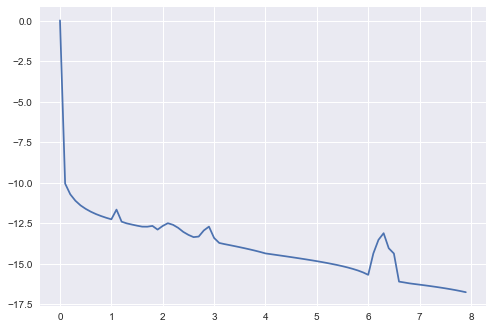

In [11]:
plt.plot(red,np.log10(SEDs[0,0,:]))

In [12]:
samples=fit.extract()

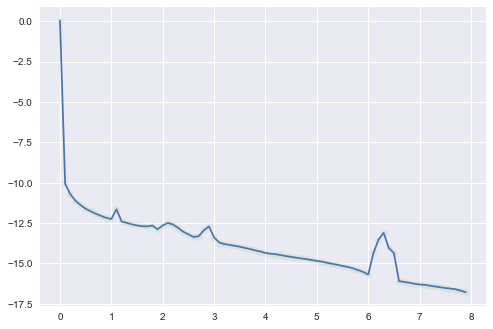

In [16]:
plt.plot(red,samples['f'][0,:-1])
plt.plot(red,np.log10(SEDs[0,0,:]),'o',alpha=0.1)

In [17]:
code="""
functions {
  vector gp_pred_rng(real[] x2,
                     vector y1, real[] x1,
                     real alpha, real rho, real sigma, real delta) {
    int N1 = rows(y1);
    int N2 = size(x2);
    vector[N2] f2;
    {
      matrix[N1, N1] K =   cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N1));
      matrix[N1, N1] L_K = cholesky_decompose(K);

      vector[N1] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N1] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      matrix[N1, N2] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N2] f2_mu = (k_x1_x2' * K_div_y1);
      matrix[N1, N2] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N2, N2] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N2));
      f2 = multi_normal_rng(f2_mu, cov_f2);
    }
    return f2;
  }
}

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_predict;
  real x_predict[N_predict];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N_predict] f_predict = gp_pred_rng(x_predict, y, x, alpha, rho, sigma, 1e-10);
  vector[N_predict] y_predict;

  for (n in 1:N_predict)
    y_predict[n] = normal_rng(f_predict[n], sigma);
}"""

In [18]:
sm2=pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fbb57ffdb42988e1caf1e58c8b47a9f3 NOW.


In [43]:
redpred=np.random.uniform(1,4,100)

In [44]:
red=np.arange(0,8,0.1)
red[0]=0.000001
fit_data={'N':SEDs[0,0,:].size,
      'x':red,
      'y':np.log10(SEDs[0,0,:]),
      'N_predict':redpred.size,
      'x_predict':redpred,
      'rho':0.15,
      'alpha':1.0,
      'sigma':0.01
     }

In [45]:
fit2=sm2.sampling(data=fit_data, iter=1000,chains=2,algorithm="Fixed_param",warmup=0)

In [46]:
fit2

Inference for Stan model: anon_model_fbb57ffdb42988e1caf1e58c8b47a9f3.
2 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f_predict[0]  -13.25  2.3e-4   0.01 -13.27 -13.26 -13.25 -13.25 -13.23   1836    1.0
f_predict[1]  -13.84  2.2e-4 9.8e-3 -13.86 -13.85 -13.84 -13.84 -13.83   1914    1.0
f_predict[2]   -12.7  2.3e-4   0.01 -12.72 -12.71  -12.7  -12.7 -12.68   2000    1.0
f_predict[3]  -12.63  2.2e-4   0.01 -12.65 -12.64 -12.63 -12.63 -12.61   2000    1.0
f_predict[4]  -12.56  2.1e-4 9.6e-3 -12.58 -12.57 -12.56 -12.56 -12.54   2000    1.0
f_predict[5]  -13.17  2.3e-4 9.7e-3 -13.19 -13.18 -13.17 -13.16 -13.15   1777    1.0
f_predict[6]  -13.77  2.2e-4 9.8e-3 -13.79 -13.78 -13.77 -13.76 -13.75   2000    1.0
f_predict[7]  -12.52  2.3e-4   0.01 -12.54 -12.52 -12.52 -12.51  -12.5   1981    1.0
f_predict[8]  -13.28  2.4e-4   0.01  -13.3 -13.29

In [39]:
samples=fit2.extract()

(array([  13.,   36.,  121.,  302.,  449.,  490.,  362.,  151.,   66.,   10.]),
 array([-12.2758251 , -12.26693632, -12.25804754, -12.24915876,
        -12.24026997, -12.23138119, -12.22249241, -12.21360363,
        -12.20471485, -12.19582607, -12.18693729]),
 <a list of 10 Patch objects>)

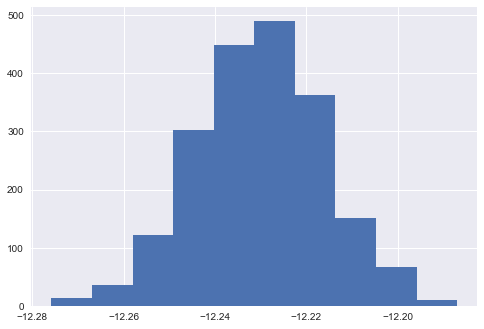

In [42]:
plt.hist(samples['y_predict'])

In [ ]:
code="""
functions {
  vector gp_pred_lpdf(real[] x2,
                     vector y1, real[] x1,
                     real alpha, real rho, real sigma, real delta,vector src_f) {
    int N1 = rows(y1);
    int N2 = size(x2);
    vector[N2] f2;
    {
      matrix[N1, N1] K =   cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N1));
      matrix[N1, N1] L_K = cholesky_decompose(K);

      vector[N1] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N1] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      matrix[N1, N2] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N2] f2_mu = (k_x1_x2' * K_div_y1);
      matrix[N1, N2] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N2, N2] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N2));
      multi_normal_lpdf(f2_mu, cov_f2);
    }
    return multi_normal_lpdf(src_f|f2_mu,cov_f2);
  }
}

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_predict;
  real x_predict[N_predict];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N_predict] f_predict = gp_pred_rng(x_predict, y, x, alpha, rho, sigma, 1e-10);
  vector[N_predict] y_predict;

  for (n in 1:N_predict)
    y_predict[n] = normal_rng(f_predict[n], sigma);
}"""